# Movie Revenue and Profit Prediction 

This notebook works through classification models related to predicting the box office profit of movies released between 1995 and June 2018.  The related GitHub for this project is here: https://github.com/georgetown-analytics/Box-Office.  

The raw data sources were cleaned, wrangled, and had some pre-processing performed on them in separate python codes stored here: https://github.com/georgetown-analytics/Box-Office/tree/master/codes.  

The final dataset is stored in a SQLite database here: https://github.com/georgetown-analytics/Box-Office/tree/master/database.

This notebook is for the modeling stage of the project and includes classification models.

In [1]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, 
    LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV)
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.neural_network import MLPClassifier

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score,confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from yellowbrick.classifier import ClassificationReport, ROCAUC
from yellowbrick.features import FeatureImportances

from imblearn.over_sampling import SMOTE

from sklearn.tree import export_graphviz
import pydot

%matplotlib inline

C:\Users\Rebecca\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con = sql.connect(r'c:\users\rebecca\projs\Box-Office\database\movies.db') 

data = pd_sql.read_sql('select * from finalMovies_20180814', con, index_col='index')




# Classification Models

We can try to develop classes of movies in order to use classification models.  So, this section will look at whether we can predict movie profitability.  We will use a feature we created during the pre-processing step: "Profit_Bucket", which indicates whether a movie made less than its budget, same as its budget, twice its budget, three times, etc.  The classes are: <1x, [1-2x), [2-3x), [3-4x), [4-5x), and >=5x.  

From this, we will create an additional feature called "Profit_Bucket_Binary" which will equal a 1 if the movie made at least twice its budget, and 0 if not.  We chose this threshold because in some of the literature regarding movie profitability, a rule-of-thumb some people follow is a movie likely makes a profit if it makes at least twice its production budget.  This is due to the extra costs of marketing, distribution, and other expenses.

Some of the codes to run models were taken from some labs we did in Dr. Bari's class and Dr. Bengfort's class.

### Create Profit Bucket Binary variable and set (X, y) train and test sets

We will create the new feature "Profit_Bucket_Binary", convert any "nan" in the historical cast/crew revenue columns to 0, and set the train and test sets that we will use for all the classification model testing. 

In [3]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $500,000, if 
#we choose to.
movies = data[(data['Revenue_Real']>0)&(data['Budget_Real']>0)&(data['Length']>0)&(data['Year']>=2008)]

#Make binary variable for if movie made at least 2x budget
movies['Profit_Bucket_Binary']=np.where(movies['Profit_Bucket']=='<1x', 0, np.where(movies['Profit_Bucket']=='[1-2x)', 
                        0, np.where(movies['Profit_Bucket']=='[2-3x)', 1, np.where(movies['Profit_Bucket']=='[3-4x)', 
                        1, np.where(movies['Profit_Bucket']=='[4-5x)', 1, np.where(movies['Profit_Bucket']=='>=5x', 1, ''))))))

#Put zero where null
movies['Revenue_Actor_Real']=movies['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
movies['Revenue_Director_Real']=movies['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
movies['Revenue_Writer_Real']=movies['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)


C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

0    1346
1    1049
Name: Profit_Bucket_Binary, dtype: int64


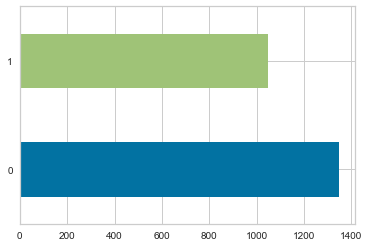

In [4]:
#Show distribution of profit bucket binary
print(movies['Profit_Bucket_Binary'].value_counts())
movies['Profit_Bucket_Binary'].value_counts().plot(kind='barh')
plt.show()

### As done in the Regression modeling Jupyter notebook, let's remove any Awards categories and imdbVotes, even though they are good predictors of movie revenue.  

In [5]:
#Set X, y
X = movies[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real']]
y = movies["Profit_Bucket_Binary"]

In [6]:
scaler = StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
X_std = min_max_scaler.fit_transform(X)

In [7]:
#Do split to make plotting with Yellowbrick easier, but will be using k-fold to get actual scores.
seed=3
X_train_std, X_test_std, y_train_std, y_test_std = cross_validation.train_test_split(X_std, y, test_size = 0.2, random_state=seed)


In [8]:
classifiers = [
    LogisticRegressionCV(random_state=1, cv=5),
    LogisticRegression(random_state=1),
    RandomForestClassifier(n_estimators=50, oob_score=True),
    XGBClassifier(),   
    BaggingClassifier(), 
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MultinomialNB(),
    GaussianNB(),
    SGDClassifier(),
    MLPClassifier(),
    #SVC(kernel='linear'),
    SVC(kernel='rbf'),
    #SVC(kernel='poly', degree=3),
    KNeighborsClassifier()]

LogisticRegressionCV 
              precision    recall  f1-score   support

          0       0.72      0.80      0.76      1346
          1       0.70      0.60      0.65      1049

avg / total       0.71      0.71      0.71      2395



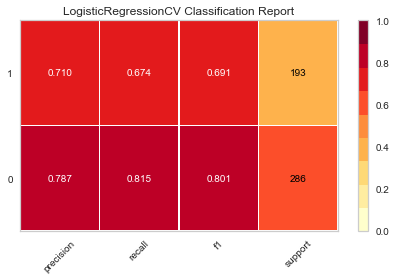

LogisticRegression 
              precision    recall  f1-score   support

          0       0.71      0.80      0.75      1346
          1       0.69      0.59      0.64      1049

avg / total       0.71      0.71      0.70      2395



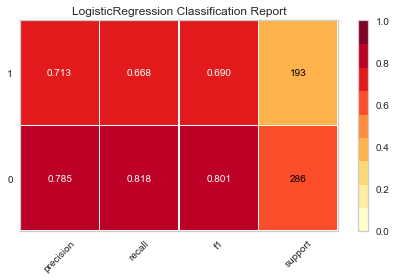

RandomForestClassifier 
              precision    recall  f1-score   support

          0       0.73      0.83      0.78      1346
          1       0.73      0.60      0.66      1049

avg / total       0.73      0.73      0.73      2395



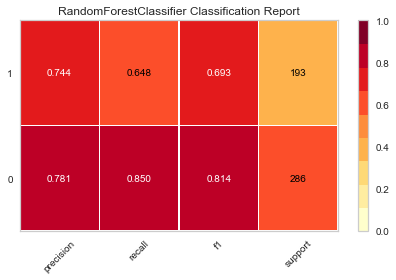

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning Fals

XGBClassifier 
              precision    recall  f1-score   support

          0       0.73      0.85      0.78      1346
          1       0.75      0.59      0.66      1049

avg / total       0.74      0.74      0.73      2395



C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


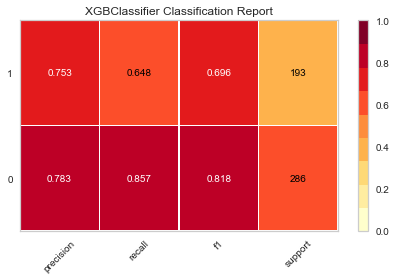

BaggingClassifier 
              precision    recall  f1-score   support

          0       0.71      0.82      0.76      1346
          1       0.71      0.57      0.63      1049

avg / total       0.71      0.71      0.71      2395



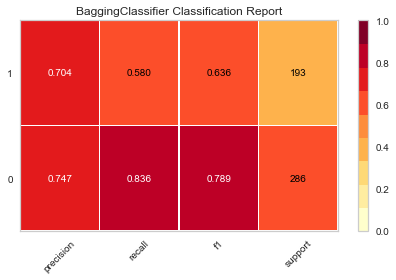

ExtraTreesClassifier 
              precision    recall  f1-score   support

          0       0.69      0.81      0.75      1346
          1       0.69      0.54      0.61      1049

avg / total       0.69      0.69      0.69      2395



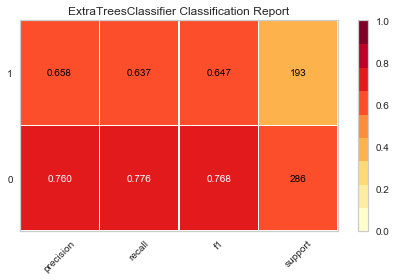

AdaBoostClassifier 
              precision    recall  f1-score   support

          0       0.73      0.80      0.77      1346
          1       0.71      0.62      0.67      1049

avg / total       0.72      0.73      0.72      2395



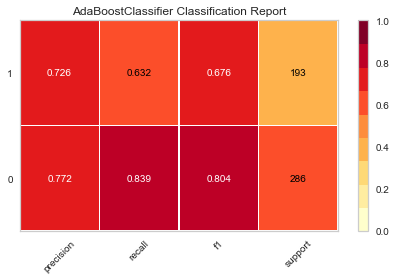

GradientBoostingClassifier 
              precision    recall  f1-score   support

          0       0.73      0.83      0.78      1346
          1       0.74      0.61      0.67      1049

avg / total       0.73      0.73      0.73      2395



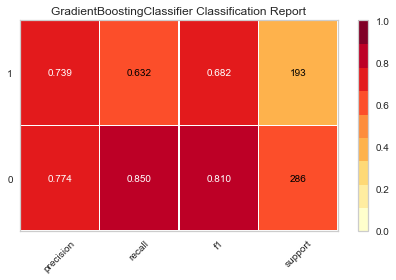

MultinomialNB 
              precision    recall  f1-score   support

          0       0.67      0.80      0.73      1346
          1       0.66      0.50      0.57      1049

avg / total       0.67      0.67      0.66      2395



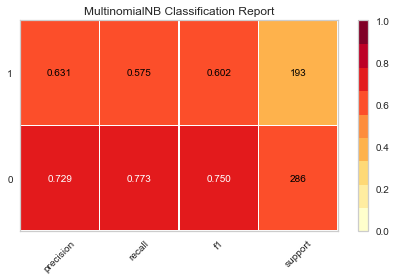

GaussianNB 
              precision    recall  f1-score   support

          0       0.67      0.82      0.74      1346
          1       0.67      0.47      0.56      1049

avg / total       0.67      0.67      0.66      2395



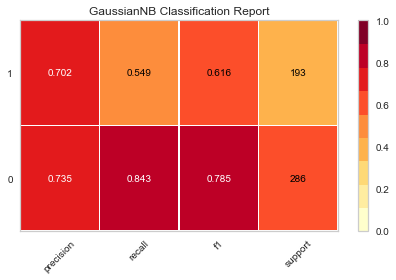

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Rebecca\Anaconda3\l

SGDClassifier 
              precision    recall  f1-score   support

          0       0.67      0.78      0.72      1346
          1       0.65      0.51      0.57      1049

avg / total       0.66      0.66      0.66      2395



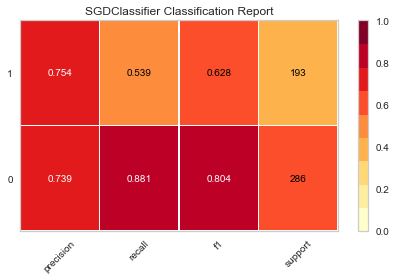

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier 
              precision    recall  f1-score   support

          0       0.73      0.78      0.75      1346
          1       0.69      0.64      0.66      1049

avg / total       0.71      0.72      0.71      2395



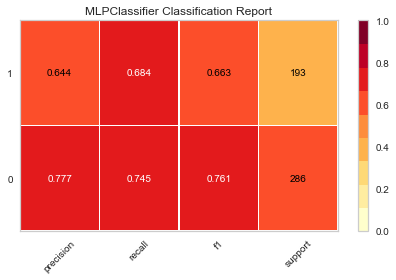

SVC 
              precision    recall  f1-score   support

          0       0.67      0.89      0.77      1346
          1       0.76      0.44      0.56      1049

avg / total       0.71      0.69      0.68      2395



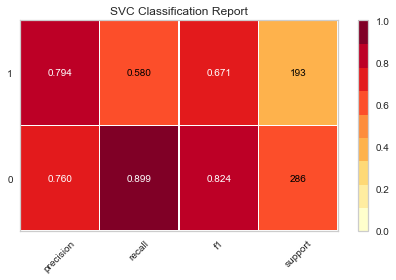

KNeighborsClassifier 
              precision    recall  f1-score   support

          0       0.68      0.81      0.74      1346
          1       0.67      0.51      0.58      1049

avg / total       0.68      0.68      0.67      2395



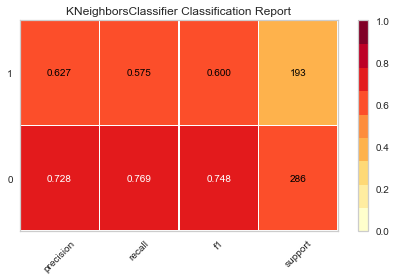

In [9]:
for clf in classifiers:

    name = clf.__class__.__name__
    y_pred = cross_val_predict(clf,X_std,y,cv=10)
    class_report = classification_report(y,y_pred)
    print(name, '\n', class_report)
    
    #scoring_list = ['accuracy']#', 'precision', 'recall', 'f1', 'roc_auc']
    #scores = cross_validate(clf, X_std, y, cv=10, scoring=scoring_list, return_train_score=False)
    #avg_score = scores.mean()
    #print(name, avg_score)
    
    #clf.fit(X_train, y_train)
    #expected = y_test
    #predicted = clf.predict(X_test)
    #print(name, (f1_score(expected, predicted, average=None)))
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train_std, y_train_std)
    oz.score(X_test_std, y_test_std)
    oz.poof()
    
    #label_encoder = LabelEncoder()
    #yc = label_encoder.fit_transform(y)
    #oz = ROCAUC(clf, support=True, classes=label_encoder.classes_)
    #oz.fit(X_train, y_train)
    #oz.score(X_test, y_test)
    #oz.poof()
    
    #oz=FeatureImportances(clf)
    #oz.fit(X_train, y_train)
    #oz.poof()
    

### Line to run oversampling SMOTE method, if needed. 
See if model scores improve when oversampling method is used. SMOTE used on only the training set created above, not entire dataset.

In [10]:
sm = SMOTE(random_state=12)
X_train_std, y_train_std = sm.fit_sample(X_train_std, y_train_std)

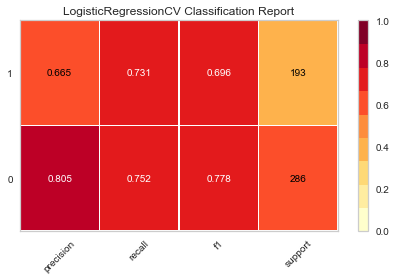

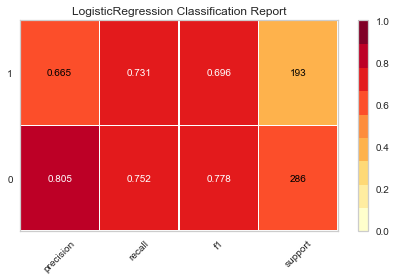

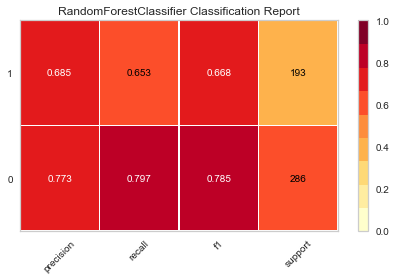

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


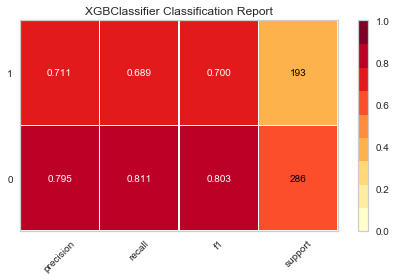

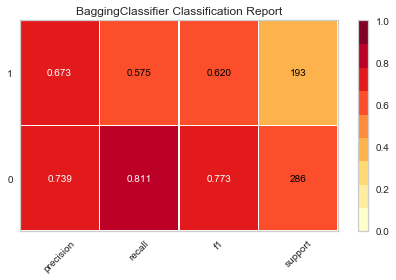

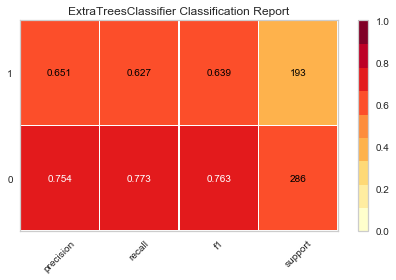

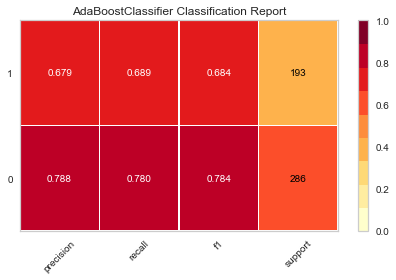

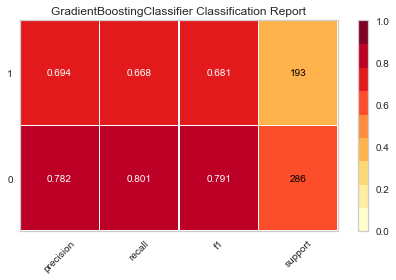

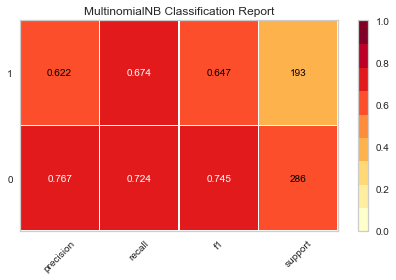

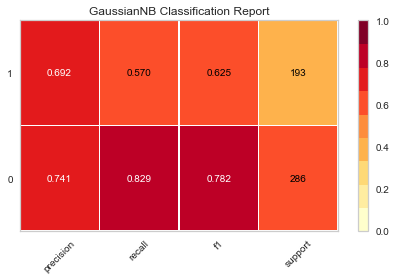

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


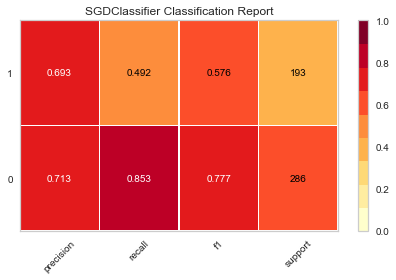

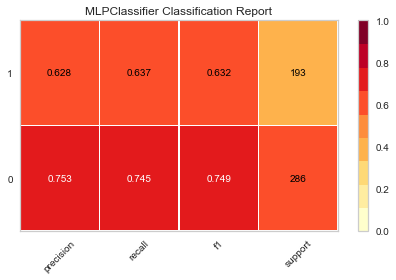

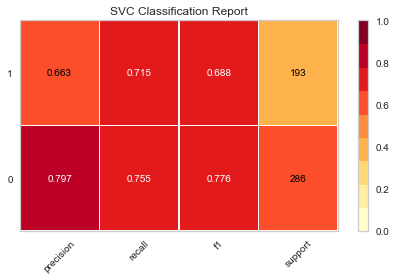

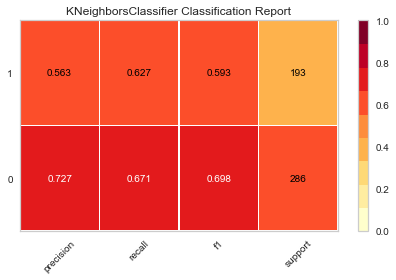

In [11]:
for clf in classifiers:

    name = clf.__class__.__name__
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train_std, y_train_std)
    oz.score(X_test_std, y_test_std)
    oz.poof()

    
    

### A look at feature importances. 
For the classifiers that have the ability to give a ranking of feature importances, use Yellowbrick to plot

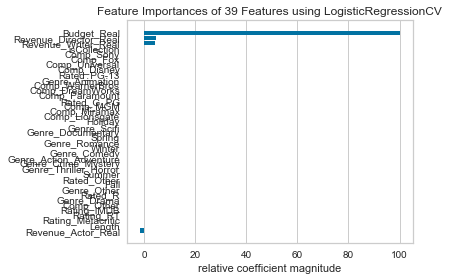

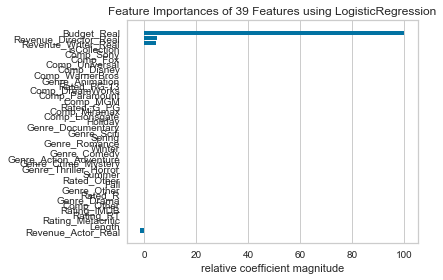

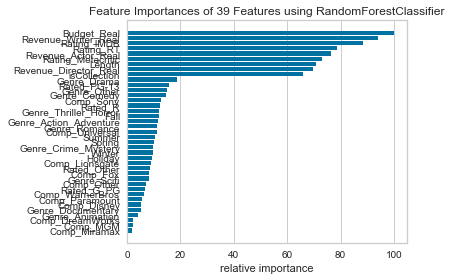

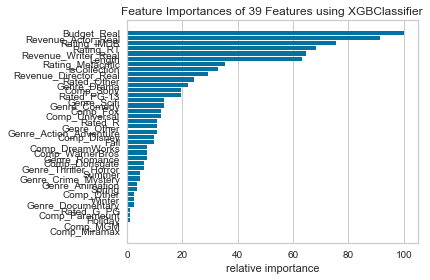

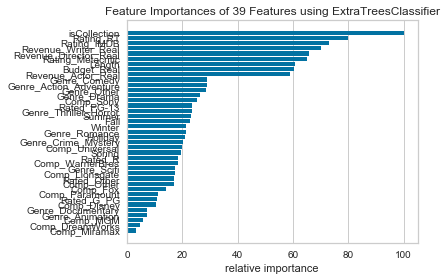

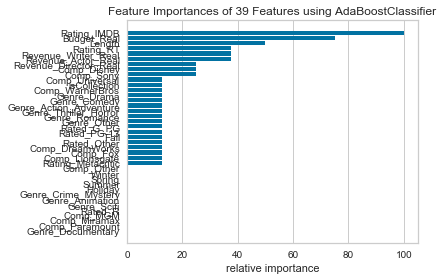

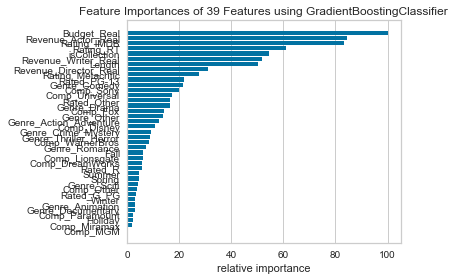

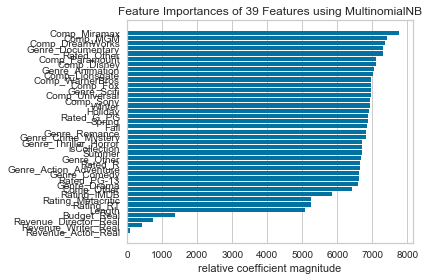

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


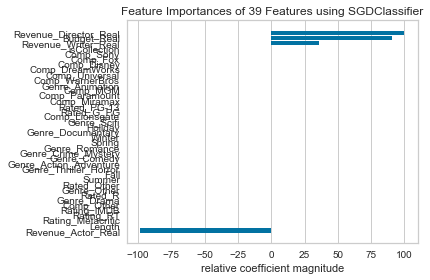

In [12]:
classifiers = [
    LogisticRegressionCV(random_state=1, cv=5),
    LogisticRegression(random_state=1),
    RandomForestClassifier(n_estimators=50, oob_score=True),
    XGBClassifier(),  
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MultinomialNB(),
    SGDClassifier()
]

for clf in classifiers:
    fig = plt.figure()
    ax = fig.add_subplot()
    
    name = clf.__class__.__name__
    
    oz=FeatureImportances(clf, ax=ax)
    oz.fit(X, y)
    oz.poof()